In [158]:
import pandas as pd
import numpy as np
import seaborn as sb
from tqdm import tqdm_notebook as tqdm
from collections import OrderedDict
import multiprocessing as mp
import os

!pip install --upgrade pip
!pip install cesium

from cesium.time_series import TimeSeries
import cesium.featurize as featurize

import matplotlib.pyplot as plt

Requirement already up-to-date: pip in /Users/dkomlen/anaconda3/lib/python3.7/site-packages (18.1)


### Baseline

In [2]:
sample = pd.read_csv('data/sample_submission.csv')

In [3]:
baseline = pd.DataFrame(0.066, index=np.arange(len(sample)), columns=sample.columns)
baseline['object_id'] = sample['object_id']

In [26]:
baseline.to_csv('baseline_submission.csv.gz', compression='gzip', index=False)

### Data exploration

In [98]:
!ls -hal data/*.csv

-rw-r--r--  1 dkomlen  ANT\Domain Users   330M Oct 28 12:15 data/baseline_submission.csv
-rwxrwxrwx  1 dkomlen  ANT\Domain Users   130M Sep 27 20:11 data/sample_submission.csv
-rw-r--r--  1 dkomlen  ANT\Domain Users   1.4G Oct 28 12:00 data/test_set.csv
-rwxrwxrwx  1 dkomlen  ANT\Domain Users    37M Sep 27 20:11 data/test_set_sample.csv
-rwxrwxrwx  1 dkomlen  ANT\Domain Users    57M Sep 27 20:11 data/training_set.csv
-rw-r--r--  1 dkomlen  ANT\Domain Users   689K Oct 28 11:53 data/training_set_metadata.csv


In [14]:
train_metadata = pd.read_csv('data/training_set_metadata.csv')
train_observations = pd.read_csv('data/training_set.csv')

display(train_metadata.head())
display(train_observations.head())

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


**Column Descriptions**

Time:
* mjd: the time in Modified Julian Date (MJD) of the observation. Can be read as days since November 17, 1858. Can be converted to Unix epoch time with the formula unix_time = (MJD−40587)×86400. Float64

Observation data:
* passband: The specific LSST passband integer, such that u, g, r, i, z, Y = 0, 1, 2, 3, 4, 5 in which it was viewed. Int8
* flux: the measured flux (brightness) in the passband of observation as listed in the passband column. These values have already been corrected for dust extinction (mwebv), though heavily extincted objects will have larger uncertainties (flux_err) in spite of the correction. Float32
* flux_err: the uncertainty on the measurement of the flux listed above. Float32
* detected: If 1, the object's brightness is significantly different at the 3-sigma level relative to the reference template. Only objects with at least 2 detections are included in the dataset. Boolean
* ddf: A flag to identify the object as coming from the DDF survey area (with value DDF = 1 for the DDF, DDF = 0 for the WFD survey). Note that while the DDF fields are contained within the full WFD survey area, the DDF fluxes have significantly smaller uncertainties. Boolean

Object info:
* object_id: unique object identifier. Int32
* target: The class of the astronomical source. This is provided in the training data. Correctly determining the target (correctly assigning classification probabilities to the objects) is the ‘goal’ of the classification challenge for the test data. Note that there is one class in the test set that does not occur in the training set: class_99 serves as an "other" class for objects that don't belong in any of the 14 classes in the training set. Int8

Object position:
* ra: right ascension, sky coordinate: co-longitude in degrees. Float32
* decl: declination, sky coordinate: co-latitude in degrees. Float32
* gal_l: galactic longitude in degrees. Float32
* gal_b: galactic latitude in degrees. Float32

Red shift info, object distance:
* hostgal_specz: the spectroscopic redshift of the source. This is an extremely accurate measure of redshift, available for the training set and a small fraction of the test set. Float32
* hostgal_photoz: The photometric redshift of the host galaxy of the astronomical source. While this is meant to be a proxy for hostgal_specz, there can be large differences between the two and should be regarded as a far less accurate version of hostgal_specz. Float32
* hostgal_photoz_err: The uncertainty on the hostgal_photoz based on LSST survey projections. Float32
* distmod: The distance to the source calculated from hostgal_photoz and using general relativity. Float32
* mwebv: MW E(B-V). this ‘extinction’ of light is a property of the Milky Way (MW) dust along the line of sight to the astronomical source, and is thus a function of the sky coordinates of the source ra, decl. This is used to determine a passband dependent dimming and redenning of light from astronomical sources as described in subsection 2.1, and based on the Schlafly et al. (2011) and Schlegel et al. (1998) dust models. Float32

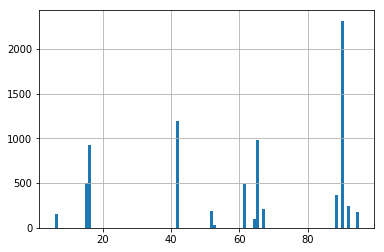

In [15]:
train_metadata['target'].hist(bins=100)

### Data preprocessing

In [28]:
pb_map = OrderedDict([(0,'u'), (1,'g'), (2,'r'), (3,'i'), (4, 'z'), (5, 'y')])

pb_cols = OrderedDict([(0,'blueviolet'), (1,'green'), (2,'red'),\
                      (3,'orange'), (4, 'black'), (5, 'brown')])

pb_names = list(pb_map.values())

In [75]:
def build_timeseries(metadata, observations):
    timeseries = OrderedDict()
    
    for _, row in tqdm(metadata.iterrows(), desc='Building timeseries', total=len(metadata)):
        obj_id = row['object_id']
        obj_target = row['target']

        obj_meta = {'z':row['hostgal_photoz'],\
                'zerr':row['hostgal_photoz_err'],\
                'mwebv':row['mwebv']}

        obj_obs = observations[observations['object_id'] == obj_id]
        pbind = [(obj_obs['passband'] == pb) for pb in pb_map]
        
        t = [obj_obs[obj_obs['passband'] == pb]['mjd'].values for pb in pb_map]
        m = [obj_obs[obj_obs['passband'] == pb]['flux'].values for pb in pb_map]
        e = [obj_obs[obj_obs['passband'] == pb]['flux_err'].values for pb in pb_map]

        timeseries[obj_id] = TimeSeries(t=t, m=m, e=e,\
                            label=obj_target, name=obj_id, meta_features=obj_meta,\
                            channel_names=pb_names)

    return timeseries

In [152]:
def worker(obj_ts):
    return featurize.featurize_single_ts(obj_ts,\
        features_to_use=["amplitude",
                   "percent_beyond_1_std",
                   "maximum",
                   "max_slope",
                   "median",
                   "median_absolute_deviation",
                   "percent_close_to_median",
                   "minimum",
                   "skew",
                   "std",
                   "weighted_average"])

def build_features(data_ts, file_prefix):
    features_file = f'data/{file_prefix}_features.npz'
    if os.path.exists(features_file):
        print(f'Loading features snaphot from file: {features_file}')
        features, _ = featurize.load_featureset(features_file)
    else:
        features_list = []
        with tqdm(total=len(data_ts), desc="Computing features") as pbar:
            pool = mp.Pool()
            for feat in pool.imap(worker, data_ts.values()):
                features_list.append(feat)
                pbar.update()
            
        features = featurize.assemble_featureset(features_list=features_list,\
                              time_series=data_ts.values())
        featurize.save_featureset(fset=features, path=features_file)
        
    # Adjust dataframe to simple table
    old_names = features.columns.values
    new_names = ['{}_{}'.format(x, pb_map.get(y,'meta')) for x,y in old_names]
    cols = [features[col].values for col in old_names]
    return pd.DataFrame(np.transpose(cols), columns=new_names)

In [90]:
train_ts = build_timeseries(train_metadata, train_observations)

In [150]:
train_features = build_features(train_ts, 'train')

Loading features snaphot from file: data/train_features.npz
69 69


In [162]:
display(train_metadata.head())
display(train_features.head())

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


,amplitude_u,amplitude_g,amplitude_r,amplitude_i,amplitude_z,amplitude_y,percent_beyond_1_std_u,percent_beyond_1_std_g,percent_beyond_1_std_r,percent_beyond_1_std_i,...,std_y,weighted_average_u,weighted_average_g,weighted_average_r,weighted_average_i,weighted_average_z,weighted_average_y,mwebv_meta,z_meta,zerr_meta
0,121.048016,880.533203,646.921722,488.190827,402.069122,400.501618,0.476190,0.586207,0.568966,0.551724,...,292.182295,-17.061118,-212.397193,-102.220639,-101.206639,-54.744845,-59.688379,0.017,0.0000,0.0000
1,14.622504,10.422385,10.298480,11.862454,11.057367,14.491025,0.385714,0.392857,0.410714,0.410714,...,7.030448,-3.500958,-1.322397,-1.030469,-1.382941,-1.407879,-1.876399,0.007,1.6267,0.2552
2,4.701063,4.543095,11.921774,19.503951,23.498145,33.234935,0.333333,0.442308,0.134615,0.115385,...,13.201397,-0.016423,-0.034170,2.059833,2.988513,4.486335,5.057690,0.021,0.2262,0.0157
3,10.944189,97.931352,111.477483,104.097369,99.563790,75.881338,0.180556,0.035714,0.071429,0.089286,...,25.822133,1.176322,3.652226,6.716857,12.514694,12.247387,8.760515,0.007,0.2813,1.1523
4,6.067815,19.896143,54.378113,71.309338,80.071971,60.009063,0.333333,0.172414,0.137931,0.103448,...,21.245772,0.824380,3.617169,7.842645,8.830427,8.463856,5.602845,0.024,0.2415,0.0176


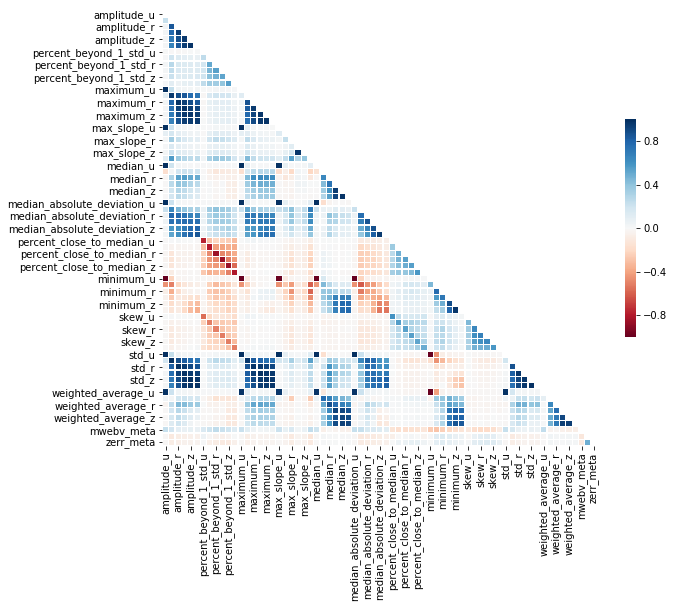

In [161]:
corr = train_features.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(10, 8))

corr_plot = sb.heatmap(corr, mask=mask, cmap='RdBu', center=0,
                square=True, linewidths=.2, cbar_kws={"shrink": .5})

### Model training